In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import pandas as pd

In [3]:
imagenet_classes = pd.read_json("imagenet_class_index.json")
imagenet_classes = imagenet_classes.T[[1]]
imagenet_classes.columns = ["Class"]
imagenet_classes

,Class
0,tench
1,goldfish
2,great_white_shark
3,tiger_shark
4,hammerhead
...,...
995,earthstar
996,hen-of-the-woods
997,bolete
998,ear


In [4]:
pretrained_model = VGG16()

553467096/553467096 [==============================] - 5s 0us/step


In [5]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Generate predictions - using Pretrained model

In [6]:
imagenet_classes.head(10)

,Class
0,tench
1,goldfish
2,great_white_shark
3,tiger_shark
4,hammerhead
5,electric_ray
6,stingray
7,cock
8,hen
9,ostrich


In [7]:
from tensorflow.keras.preprocessing.image import load_img
import numpy as np

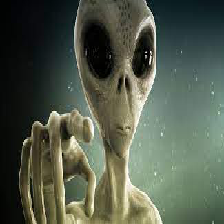

In [9]:
image_for_classification = load_img("Alien.jpeg",
                                    target_size=(224,224))
image_for_classification

In [10]:
image_for_classification = np.array(image_for_classification)
image_for_classification = preprocess_input(image_for_classification)
image_for_classification = image_for_classification.reshape(1, 224, 224, 3)

In [11]:
preds = pretrained_model.predict(image_for_classification)
imagenet_classes["probability"] = np.round(preds.flatten(), 3)
imagenet_classes.sort_values(by="probability", ascending=False)

1/1 [==============================] - 1s 1s/step


,Class,probability
616,knot,0.216
562,fountain,0.191
600,hook,0.141
488,chain,0.083
23,vulture,0.044
...,...,...
365,orangutan,0.000
366,gorilla,0.000
367,chimpanzee,0.000
369,siamang,0.000


In [ ]:
# FINETUNING THE MODEL TO PREDICT CARS OR PLANES

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import AUC
import glob

In [ ]:
# For finetuning, remove last layer from pretrained model first and freeze the other layers of the model. Then add a new output layer with freezen layers.
# That model is called baseline model.

In [13]:
baseline_model = Sequential()

for layer in pretrained_model.layers[:-1]: #Kept all layers except the last one
    layer.trainable = False
    baseline_model.add(layer)

baseline_model.add(Dense(1, activation='sigmoid')) # Adding an output layer for binary class classification

In [14]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# After removing the last layer, new output layer is added. That gives 4097 trainable parameters.
# Here, one class is added with frozen layers. Because of that (4096*1)+1=4097.

In [15]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [27]:
# Cars and planes path is loaded

cars = "/content/car1.jpeg"
planes = "/content/plane.jpeg"

In [28]:
# Data Preparation

x_train = list()
y_train = list()

for img_path in glob.glob(cars):
    input_image = load_img(img_path, target_size=(224,224))
    input_image = np.array(input_image)
    input_image = preprocess_input(input_image)
    x_train.append(input_image)
    y_train.append(0) # Cars : 0

for img_path in glob.glob(planes):
    input_image = load_img(img_path, target_size=(224,224))
    input_image = np.array(input_image)
    input_image = preprocess_input(input_image)
    x_train.append(input_image)
    y_train.append(1) # Planes : 1

In [29]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [30]:
x_train.shape

(2, 224, 224, 3)

In [31]:
# Compile and fit the data

baseline_model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy", AUC(curve="PR")])
baseline_model.fit(x=x_train, y=y_train, epochs=5, validation_split=0.2, shuffle=True)

Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.0198 - accuracy: 1.0000 - auc_2: 0.0000e+00 - val_loss: 1.1079 - val_accuracy: 0.0000e+00 - val_auc_2: 1.0000
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 6.5658e-04 - accuracy: 1.0000 - auc_2: 0.0000e+00 - val_loss: 1.4353 - val_accuracy: 0.0000e+00 - val_auc_2: 1.0000
Epoch 3/5
1/1 [==============================] - 1s 1s/step - loss: 6.1292e-05 - accuracy: 1.0000 - auc_2: 0.0000e+00 - val_loss: 1.7158 - val_accuracy: 0.0000e+00 - val_auc_2: 1.0000
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 9.7329e-06 - accuracy: 1.0000 - auc_2: 0.0000e+00 - val_loss: 1.9597 - val_accuracy: 0.0000e+00 - val_auc_2: 1.0000
Epoch 5/5
1/1 [==============================] - 1s 1s/step - loss: 2.1537e-06 - accuracy: 1.0000 - auc_2: 0.0000e+00 - val_loss: 2.1740 - val_accuracy: 0.0000e+00 - val_auc_2: 1.0000


In [ ]:
# Test Finetuned Model
# 0 - Car
# 1 - Plane

In [32]:
img = "/content/hypercar.jpeg"

In [35]:
image_for_classification = load_img(path = img ,target_size=(224,224))
image_for_classification = np.array(image_for_classification)
image_for_classification = preprocess_input(image_for_classification)
image_for_classification = image_for_classification.reshape(1, 224, 224, 3)

preds = baseline_model.predict(image_for_classification)

1/1 [==============================] - 1s 527ms/step


In [36]:
preds

array([[0.08317387]], dtype=float32)

In [ ]:
# So it is a car.  [If preds, 0 to 0.5 => car and 0.5 to 1 => plane]